[Original website of the paper](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)
  
![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

# Our Architecture
TODO:
Add time per epoch
Add model Summary


In [0]:
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import random
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates


image = Image.open('train-volume.tif')
image_label = Image.open('train-labels.tif')

batch_size = 1

class Rotate(object):
  # def __init__(self):

  def __call__(self, sample):
    img, label = sample['image'], sample['label']
    angle = random.randint(0,3)*90
    img = img.rotate(angle)
    label = label.rotate(angle)
    return {'image': img, 'label': label}


def elastic_transform(image, alpha=1000, sigma=30, spline_order=1, mode='nearest', random_state=np.random):
    image = np.array(image)
    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = [np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))]
    result = np.empty_like(image)
    result[:, :] = map_coordinates(
        image[:, :], indices, order=spline_order, mode=mode
    ).reshape(shape)
    result = Image.fromarray(result)
    return result


class ElasticTransform(object):
  def __call__(self, sample):
    img, label = sample['image'], sample['label']
    
    # Seed must be between 0 and 2^32 - 1
    seed = np.random.randint(2**32-1)
    img = elastic_transform(img, random_state=np.random.RandomState(seed))
    label = elastic_transform(label, random_state=np.random.RandomState(seed))
    
    return {'image': img, 'label': label}


# copied from tutorial 
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        # swap color axis because DID NOT DO THIS BECAUSE ONLY 1 CHANNEL
        # numpy image: H x W x C
        # torch image: C X H X W
        np_img = np.array(image) / (255)
        np_label = np.array(label) / (255)

        return {'image': torch.unsqueeze(torch.from_numpy(np_img).float(),0) ,
                'label': torch.unsqueeze(torch.from_numpy(np_label).float(),0) }


class CellDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
  
    def __len__(self):
        return image.n_frames
    
    def __getitem__(self, index):
        image.seek(index)
        image_label.seek(index)
        img = image
        img_label = image_label

        sample = {'image': img, 'label': img_label}
        sample_t = self.transform(sample)
       
        return sample_t

train_data = CellDataset(transform=transforms.Compose([Rotate(),
                                                       ElasticTransform(),
                                                       ToTensor()]));
dataloaders = {
    'train': DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
}

sample = next(iter(dataloaders['train']))
# print(sample['image'].shape, sample['label'].shape)
print(sample['image'].shape)
print(sample['label'].shape)

In [0]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=1)
        self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        #We concatenate the upsampled vector with 
        #the corresponding vector from the downward path
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


"""Main Class"""
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512, bilinear)
        self.up2 = Up(512, 256, bilinear)
        self.up3 = Up(256, 128, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [0]:
#Hyperparameters
lr = 1e-4
weight_decay = 1e-8
momentum = 0.9

def calc_loss(pred, target):
    pred = torch.sigmoid(pred).contiguous()
    target = target.contiguous()  
    bce_loss = F.binary_cross_entropy_with_logits(pred, target)
    return bce_loss.mean()

def train_model(model, epochs):
    print("training")
    for epoch in range(epochs):
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        total_loss = 0 
        for batch in dataloaders['train']:
            pred = model(batch['image'])
            loss = calc_loss(pred,batch['label'])
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), 0.1)
            optimizer.step()
        print("epoch: ",epoch)
        print("loss: ",total_loss)

model = UNet(1,1) #1 input, 1 output
train_model(model, epochs=20)

  

training
epoch:  0
loss:  14.770488768815994
epoch:  1
loss:  13.901691377162933
epoch:  2
loss:  13.615047127008438
epoch:  3
loss:  13.46749895811081
epoch:  4
loss:  13.504294633865356
epoch:  5
loss:  13.443056464195251
epoch:  6
loss:  13.422138452529907
epoch:  7
loss:  13.381639748811722
epoch:  8
loss:  13.30833876132965
epoch:  9
loss:  13.284428775310516
epoch:  10
loss:  13.31638103723526
epoch:  11
loss:  13.283477634191513
epoch:  12
loss:  13.28348633646965
epoch:  13
loss:  13.26612052321434
epoch:  14
loss:  13.254173129796982
epoch:  15
loss:  13.288530945777893


KeyboardInterrupt: ignored

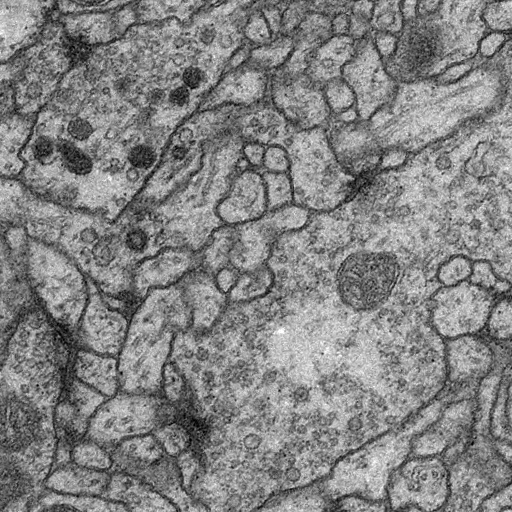

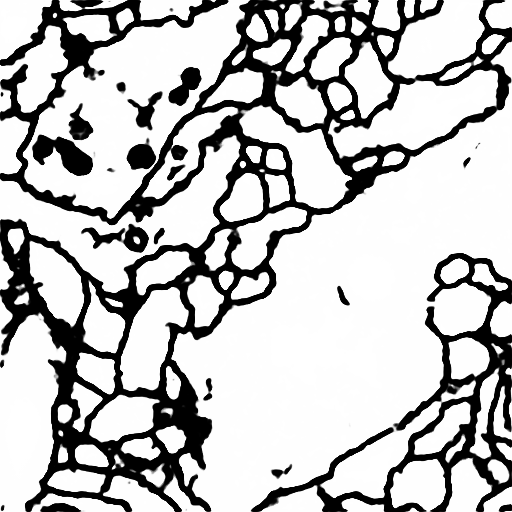

In [0]:
#Use the trained model from last cell
image_t = Image.open('test-volume.tif')

class TestDataset(Dataset):
    def __init__(self):
        self.transform = transforms.Compose([transforms.ToTensor()])
  
    def __len__(self):
        return image.n_frames
    
    def __getitem__(self, index):
        image_t.seek(index)
        img = image_t

        img_t_t = self.transform(img)
        sample = {'image': img_t_t}
        
        return sample

test_data = TestDataset()

dataloaders['test'] = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=0)

sample = next(iter(dataloaders['test']))
img = sample['image']
pred = model(img)
pred = torch.squeeze(torch.sigmoid(pred),0)

#print(img)
#print(pred)
pred_img = transforms.ToPILImage()(pred)
img = torch.squeeze(img,0)
pil_img = transforms.ToPILImage()(img)
display(pil_img)
display(pred_img)


torch.Size([1, 1, 512, 512])


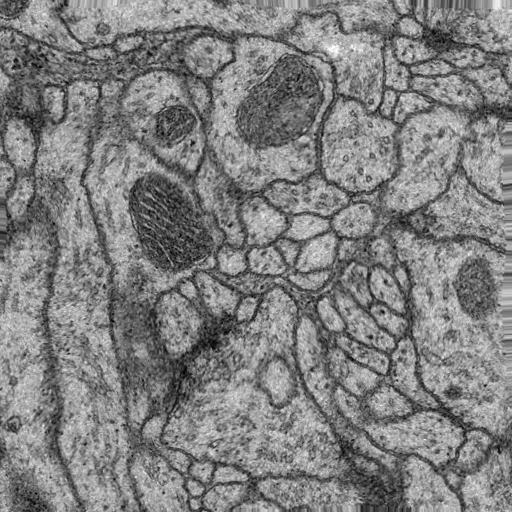

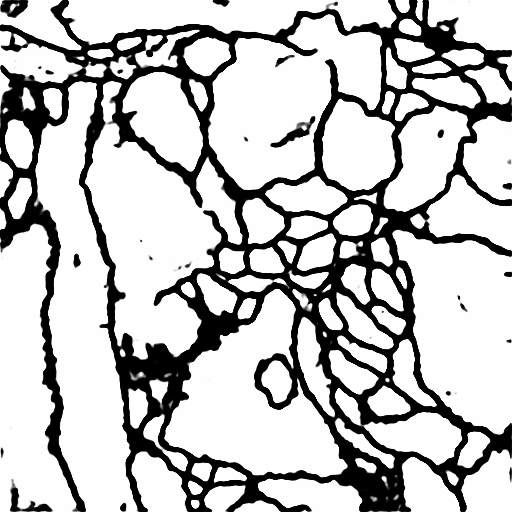

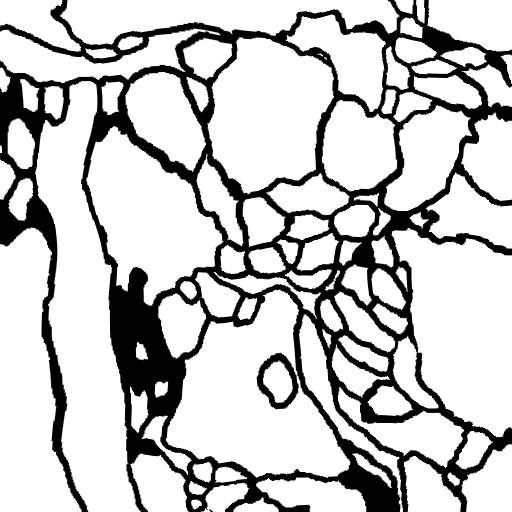

In [0]:

sample2 = next(iter(dataloaders['train']))
img2 = sample2['image']

pred_2 = model(img2)
print(pred_2.shape)
pred_2 = torch.squeeze(torch.sigmoid(pred_2),0)
pred_img_2 = transforms.ToPILImage()(pred_2)

img2 = torch.squeeze(img2,0)
pil_img2 = transforms.ToPILImage()(img2)
display(pil_img2)
display(pred_img_2)

img2_label = sample2['label']
img2_label = torch.squeeze(img2_label,0)
pil_img2_l = transforms.ToPILImage()(img2_label)
display(pil_img2_l)
